# LSTM base net Implemented by Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import tensorflow.keras as keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

import ipdb
import dan_utils

In [2]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [3]:
flow_df = pd.read_csv('../data/revised_data/flow_y_revised.csv')
flow = flow_df.to_numpy()

In [4]:
flow.shape

(40, 4464)

# Data assembling

In [5]:
# # sliding window
# window_size = 10
# pred_size = 20
# train_X = np.zeros([flow.shape[0] - window_size - pred_size + 1, window_size, flow.shape[1]])
# train_y = np.zeros(train_X.shape[0], pred_size)

# for i in range(window_size):
#     train_X[:, i, :] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]
#     # train_y[:, i] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]


In [6]:
def sliding_window(data, window_size, pred_samp, prop):
    
#     data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[1] - window_size - pred_samp):
        data_out.append(data[:, i : i + window_size])
        # to predict the next [window size] flows
        label_out.append(data[:, i + window_size + 1: i + window_size + 1 + pred_samp])
    data_out = np.array(data_out)
    label_out = np.array(label_out)
#     ipdb.set_trace()
    train_data_out = data_out[:int(data_out.shape[0]*prop), :]
    train_label_out = label_out[:int(data_out.shape[0]*prop)]
    val_data_out = data_out[int(data_out.shape[0]*prop):, :]
    val_label_out = label_out[int(data_out.shape[0]*prop):]
    
    train_data_out = np.transpose(train_data_out, [0, 2, 1])
    train_label_out = np.transpose(train_label_out, [0, 2, 1])
    val_data_out = np.transpose(val_data_out, [0, 2, 1])
    val_label_out = np.transpose(val_label_out, [0, 2, 1])
    
    return train_data_out, train_label_out, val_data_out, val_label_out


In [7]:
window_size = 10
pred_samp = 10

train_X, train_y, test_X, test_y = sliding_window(flow, window_size, pred_samp, 24/31)

In [8]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3440, 10, 40)
(3440, 10, 40)
(1004, 10, 40)
(1004, 10, 40)


# LSTM network (base)

In [9]:
# data at the position of "number of detectors" are the same
assert train_X.shape[2] == train_y.shape[2]
assert train_X.shape[2] == test_X.shape[2]
assert train_X.shape[2] == test_y.shape[2]
num_det = flow.shape[0]

hid_dim = 40

In [10]:
train_X.shape

(3440, 10, 40)

In [11]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
# model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(num_det, activation='relu'))

# Training on target data

In [12]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=400, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=True)

Epoch 1/400
27/27 - 5s - loss: 240135.3438 - val_loss: 242453.2656
Epoch 2/400
27/27 - 0s - loss: 239594.4219 - val_loss: 241693.0938
Epoch 3/400
27/27 - 0s - loss: 238863.0156 - val_loss: 240667.7500
Epoch 4/400
27/27 - 0s - loss: 237987.6875 - val_loss: 239670.5000
Epoch 5/400
27/27 - 0s - loss: 237055.6719 - val_loss: 238870.2969
Epoch 6/400
27/27 - 0s - loss: 236070.9219 - val_loss: 237874.8906
Epoch 7/400
27/27 - 0s - loss: 235006.3125 - val_loss: 236916.2969
Epoch 8/400
27/27 - 0s - loss: 233865.7969 - val_loss: 236196.8594
Epoch 9/400
27/27 - 0s - loss: 232632.4219 - val_loss: 235183.0156
Epoch 10/400
27/27 - 0s - loss: 231296.7031 - val_loss: 233947.4688
Epoch 11/400
27/27 - 0s - loss: 229869.4531 - val_loss: 232294.8281
Epoch 12/400
27/27 - 0s - loss: 228367.3750 - val_loss: 230452.1094
Epoch 13/400
27/27 - 0s - loss: 226786.2656 - val_loss: 229108.1719
Epoch 14/400
27/27 - 0s - loss: 225113.9219 - val_loss: 227004.0469
Epoch 15/400
27/27 - 0s - loss: 223365.7656 - val_loss: 2

Epoch 123/400
27/27 - 0s - loss: 94593.5625 - val_loss: 97016.5078
Epoch 124/400
27/27 - 0s - loss: 94612.8906 - val_loss: 97059.2656
Epoch 125/400
27/27 - 0s - loss: 94590.8281 - val_loss: 97051.9922
Epoch 126/400
27/27 - 0s - loss: 94434.4375 - val_loss: 96967.4766
Epoch 127/400
27/27 - 0s - loss: 94565.8828 - val_loss: 97049.0234
Epoch 128/400
27/27 - 0s - loss: 94616.7344 - val_loss: 97215.6016
Epoch 129/400
27/27 - 0s - loss: 94391.7109 - val_loss: 96902.3516
Epoch 130/400
27/27 - 0s - loss: 94543.1172 - val_loss: 96863.8594
Epoch 131/400
27/27 - 0s - loss: 94472.5234 - val_loss: 96893.9141
Epoch 132/400
27/27 - 0s - loss: 94390.4688 - val_loss: 96856.5547
Epoch 133/400
27/27 - 0s - loss: 94343.8125 - val_loss: 97123.0625
Epoch 134/400
27/27 - 0s - loss: 94213.0625 - val_loss: 96701.2500
Epoch 135/400
27/27 - 0s - loss: 94408.4766 - val_loss: 96791.8125
Epoch 136/400
27/27 - 0s - loss: 94227.7188 - val_loss: 96757.7109
Epoch 137/400
27/27 - 0s - loss: 94147.8047 - val_loss: 96832.

Epoch 246/400
27/27 - 0s - loss: 92909.6250 - val_loss: 95474.4844
Epoch 247/400
27/27 - 0s - loss: 92999.9609 - val_loss: 95528.0000
Epoch 248/400
27/27 - 0s - loss: 92822.2266 - val_loss: 95611.2500
Epoch 249/400
27/27 - 0s - loss: 92866.0547 - val_loss: 95511.7891
Epoch 250/400
27/27 - 0s - loss: 92890.0391 - val_loss: 95513.3125
Epoch 251/400
27/27 - 0s - loss: 92766.0938 - val_loss: 95745.6406
Epoch 252/400
27/27 - 0s - loss: 92819.9375 - val_loss: 95552.4766
Epoch 253/400
27/27 - 0s - loss: 92854.6406 - val_loss: 95751.9375
Epoch 254/400
27/27 - 0s - loss: 92817.3203 - val_loss: 95399.4922
Epoch 255/400
27/27 - 0s - loss: 92875.1406 - val_loss: 95659.9609
Epoch 256/400
27/27 - 0s - loss: 92771.4688 - val_loss: 95338.8828
Epoch 257/400
27/27 - 0s - loss: 92809.1172 - val_loss: 95483.3906
Epoch 258/400
27/27 - 0s - loss: 92747.8125 - val_loss: 95481.3516
Epoch 259/400
27/27 - 0s - loss: 92746.4766 - val_loss: 95527.4844
Epoch 260/400
27/27 - 0s - loss: 92776.7891 - val_loss: 95378.

Epoch 369/400
27/27 - 0s - loss: 69657.2969 - val_loss: 72635.5312
Epoch 370/400
27/27 - 0s - loss: 69292.3750 - val_loss: 72038.0469
Epoch 371/400
27/27 - 0s - loss: 68778.0312 - val_loss: 71694.1094
Epoch 372/400
27/27 - 0s - loss: 68539.9844 - val_loss: 71730.2891
Epoch 373/400
27/27 - 0s - loss: 68225.8203 - val_loss: 71088.9375
Epoch 374/400
27/27 - 0s - loss: 67742.9766 - val_loss: 70373.8672
Epoch 375/400
27/27 - 0s - loss: 66659.2500 - val_loss: 69616.4844
Epoch 376/400
27/27 - 0s - loss: 62345.2148 - val_loss: 70854.1250
Epoch 377/400
27/27 - 0s - loss: 59195.9922 - val_loss: 71831.8672
Epoch 378/400
27/27 - 0s - loss: 55876.1484 - val_loss: 69808.5156
Epoch 379/400
27/27 - 0s - loss: 53476.8516 - val_loss: 71217.3828
Epoch 380/400
27/27 - 0s - loss: 51454.1680 - val_loss: 60810.3633
Epoch 381/400
27/27 - 0s - loss: 49413.3320 - val_loss: 51677.2227
Epoch 382/400
27/27 - 0s - loss: 47338.2344 - val_loss: 52713.8750
Epoch 383/400
27/27 - 0s - loss: 45452.8867 - val_loss: 54453.

# Visualization

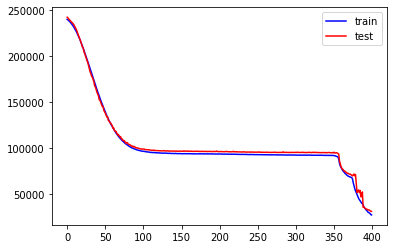

In [13]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

In [14]:
yhat = model.predict(test_X)

In [15]:
test_y.shape

(1004, 10, 40)

Text(0.5, 1.0, 'Testing dataset')

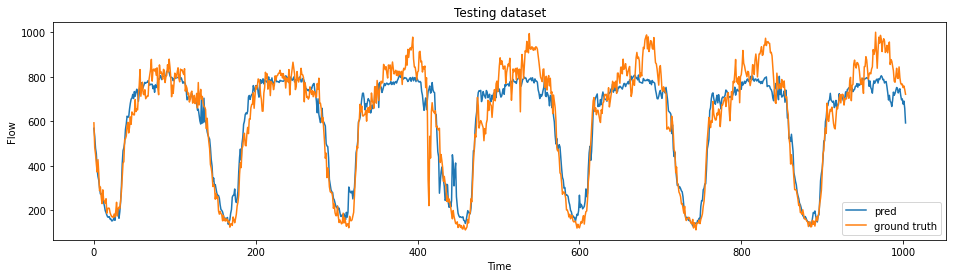

In [16]:
n_step_ahead = 3
det = 0

plt.figure(figsize=[16,4])
plt.plot(yhat[:, n_step_ahead, det], label='pred')
plt.plot(test_y[:, n_step_ahead, det], label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 15 min
plt.ylabel('Flow')
plt.title('Testing dataset')

# Evaluation

In [17]:
#transfer with DAN 预测精度计算
m=0
model_pre = yhat
label_test_target = test_y

nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test_target, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.35772351517567036
mape = 0.3438372769103601
smape = 0.2320141570451203
mae = 101.17149952285037
